In [217]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [218]:
# general settings
device = torch.device('cuda' if use_gpu else 'cpu')
print('device:', device)

# batchsize
batchsize = 100

# random seed
seed = 1
torch.manual_seed(seed)

if use_gpu:
    torch.cuda.manual_seed(seed)

device: cuda


In [219]:
# compose transformsted))
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# using SVHN dataset
training_data = datasets.SVHN(root = '../../data', split = 'train', transform = tf, download = True)
test_data = datasets.SVHN(root = '../../data', split = 'test', transform = tf, download = True)

Using downloaded and verified file: ../../data/train_32x32.mat
Using downloaded and verified file: ../../data/test_32x32.mat


In [220]:
# split to training data and validation data
train_data, validation_data = train_test_split(training_data, test_size = 0.2, random_state = seed)
print('The number of training data:', len(train_data))
print('The number of validation data', len(validation_data))

The number of training data: 58605
The number of validation data 14652


In [221]:
# prepare data loader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = False)

In [222]:
# define downsampling parts for convenience
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Downsampler, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def only_conv(self, x):
        return self.cv(x)
        
    def forward(self, x):
        out = self.cv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [223]:
# define upsampling parts for convenience
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Upsampler, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.tc(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [299]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
                            Downsampler(  3,  16),
                            Downsampler( 16,  32),
                            Downsampler( 32,  64),
                            Downsampler( 64, 128)
        )
        
        self.decoder = nn.Sequential(
                            Upsampler( 128, 64),
                            Upsampler(  64, 32),
                            Upsampler(  32, 16),
                            nn.ConvTranspose2d( 16, 3, kernel_size = 4, stride = 2, padding = 1)
        )
        
    def get_feature_map(self, x, n_layers):
        if n_layers > len(self.encoder) or n_layers < 1:
            raise ValueError('n_layres must be in [1,2,...len(self_encoder)]')
            
        for i in range(n_layers-1):
            x = self.encoder[i](x)
        out = self.encoder[n_layers-1].only_conv(x)
        return out
        
    def forward(self, x):
        encode_x = self.encoder(x)
        recon_x = torch.tanh(self.decoder(encode_x))
        return recon_x

In [300]:
net = AutoEncoder().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay = 0.0002)

loss_fn = nn.MSELoss()

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 346659

Model:
 AutoEncoder(
  (encoder): Sequential(
    (0): Downsampler(
      (cv): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (1): Downsampler(
      (cv): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (2): Downsampler(
      (cv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (3): Downsampler(
      (cv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Ups

In [301]:
# the function run training for 1 epoch
def train(train_loader):
    net.train()
    
    running_loss = 0
    
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    
    return average_loss

In [302]:
# the function run validation
def validation(validation_loader):
    net.eval()
    
    running_loss = 0
    
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            running_loss += loss_fn(outputs, inputs).item()
    
    average_loss = running_loss / len(validation_loader)
    
    return average_loss

In [303]:
n_epochs = 10
for epoch in range(n_epochs):
    train_loss = train(train_loader)
    validation_loss = validation(validation_loader)
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' %(epoch+1, n_epochs, train_loss, validation_loss))

epoch[1/10] train_loss:0.0249 validation_loss:0.0399
epoch[2/10] train_loss:0.0091 validation_loss:0.0615
epoch[3/10] train_loss:0.0075 validation_loss:0.0445
epoch[4/10] train_loss:0.0068 validation_loss:0.0523
epoch[5/10] train_loss:0.0065 validation_loss:0.0289
epoch[6/10] train_loss:0.0063 validation_loss:0.0289
epoch[7/10] train_loss:0.0061 validation_loss:0.0344
epoch[8/10] train_loss:0.0057 validation_loss:0.0256
epoch[9/10] train_loss:0.0054 validation_loss:0.0319
epoch[10/10] train_loss:0.0053 validation_loss:0.0337


In [304]:
def random_erase_for_test(tensor, erasing_height=4, erasing_width=4):
    batchsize, channels, height, width = tensor.size()
    
    for b in range(batchsize):
        erasing_h = np.random.randint(height - erasing_height)
        erasing_h = [erasing_h, erasing_h + erasing_height]
        erasing_w = np.random.randint(width - erasing_width)
        erasing_w = [erasing_w, erasing_w + erasing_width]
        tensor[b][:, \
                  erasing_h[0]:erasing_h[1], \
                  erasing_w[0]:erasing_w[1]] = torch.ones(erasing_height, erasing_width)
    return tensor

test_loader = DataLoader(test_data, batch_size = batchsize, shuffle = True)

In [305]:
net.eval()
with torch.no_grad():
    test_input = iter(test_loader).next()[0].to(device)
    test_input = random_erase_for_test(test_input)
    test_output = net(test_input)

In [306]:
def show_image(img):
    npimg = img.cpu().numpy() * 0.5 + 0.5
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

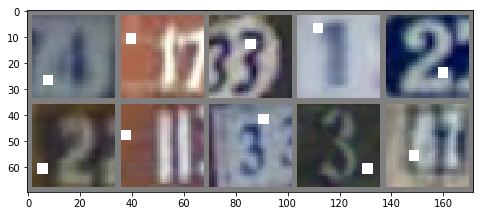

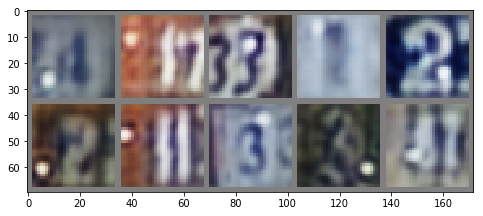

In [307]:
inputs = make_grid(test_input[:10], nrow = 5)
outputs = make_grid(test_output[:10], nrow = 5)
differences = make_grid(torch.abs(test_input[:10] - test_output[:10]), nrow = 5).mean(dim = 0)
show_image(inputs)
show_image(outputs)

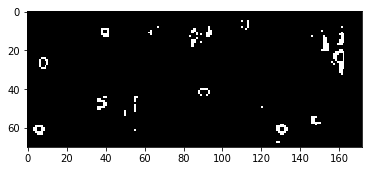

In [308]:
plt.imshow(differences > 0.3, cmap = 'gray')

In [309]:
class Auto_Feature_Encoder(nn.Module):
    def __init__(self):
        super(Auto_Feature_Encoder, self).__init__()
        self.encoder = nn.Sequential(
                            Downsampler(16,  32),
                            Downsampler(32,  32),
                            Downsampler(32,  64)
        )
        
        self.decoder = nn.Sequential(
                            Upsampler(64, 32),
                            Upsampler(32, 32),
                            nn.ConvTranspose2d(32, 16, kernel_size = 4, stride = 2, padding = 1)
        )
        
    def forward(self, x):
        embed_x = self.encoder(x)
        recon_x = self.decoder(embed_x)
        return recon_x

In [318]:
net2 = Auto_Feature_Encoder().to(device)

optimizer2 = optim.Adam(net2.parameters(), lr = 0.0001, weight_decay = 0.0001)

loss_fn2 = nn.MSELoss()

In [319]:
# the function run training for 1 epoch
def train2(train_loader):
    net.eval()
    net2.train()
    
    running_loss = 0
    
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            feature_maps = net.get_feature_map(inputs, 1)
        outputs = net2(feature_maps)
        loss = loss_fn2(outputs, feature_maps)
        
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    
    return average_loss

In [320]:
# the function run validation
def validation2(validation_loader):
    net.eval()
    net2.eval()
    
    running_loss = 0
    
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            feature_maps = net.get_feature_map(inputs, 1)
            outputs = net2(feature_maps)
            running_loss += loss_fn2(outputs, feature_maps).item()
    
    average_loss = running_loss / len(validation_loader)
    
    return average_loss

In [321]:
n_epochs = 20
for epoch in range(n_epochs):
    train_loss = train2(train_loader)
    validation_loss = validation2(validation_loader)
    
    print('epoch[%2d/%2d] train_loss:%1.7f validation_loss:%1.7f' %(epoch+1, n_epochs, train_loss, validation_loss))

epoch[ 1/20] train_loss:0.0043509 validation_loss:0.0077001
epoch[ 2/20] train_loss:0.0015358 validation_loss:0.0046302
epoch[ 3/20] train_loss:0.0009933 validation_loss:0.0035556
epoch[ 4/20] train_loss:0.0007556 validation_loss:0.0028617
epoch[ 5/20] train_loss:0.0006325 validation_loss:0.0024328
epoch[ 6/20] train_loss:0.0005517 validation_loss:0.0019622
epoch[ 7/20] train_loss:0.0005025 validation_loss:0.0022834
epoch[ 8/20] train_loss:0.0004595 validation_loss:0.0017035
epoch[ 9/20] train_loss:0.0004362 validation_loss:0.0015460
epoch[10/20] train_loss:0.0004090 validation_loss:0.0015955
epoch[11/20] train_loss:0.0003904 validation_loss:0.0014667
epoch[12/20] train_loss:0.0003737 validation_loss:0.0017975
epoch[13/20] train_loss:0.0003543 validation_loss:0.0014054
epoch[14/20] train_loss:0.0003442 validation_loss:0.0013329
epoch[15/20] train_loss:0.0003291 validation_loss:0.0013317
epoch[16/20] train_loss:0.0003223 validation_loss:0.0010213
epoch[17/20] train_loss:0.0003137 valida

In [364]:
net.eval()
net2.eval()
with torch.no_grad():
    test_input = iter(test_loader).next()[0].to(device)
    test_input = random_erase_for_test(test_input)
    test_output = net(test_input)
    feature_map = net.get_feature_map(test_input, 1)
    test_output2 = net2(feature_map)

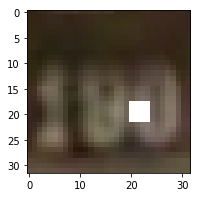

In [366]:
plt.figure(figsize = (3,3))
plt.imshow(np.transpose(inputs.cpu().numpy()*0.5 + 0.5, [1, 2, 0]))

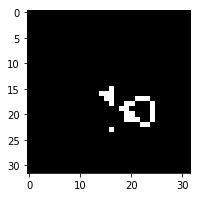

In [375]:
plt.figure(figsize = (3,3))fdaf
differences = torch.abs(inputs - outputs).mean(dim = 0)
plt.imshow(differences > 0.3, cmap = 'gray')

In [368]:
inputs2 = feature_map[index]
outputs2 = test_output2[index]

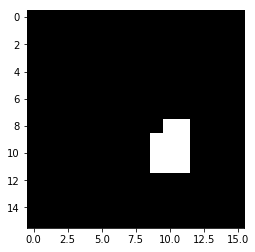

In [373]:
plt.imshow(torch.abs(inputs2 - outputs2).mean(dim = 0) > 0.05, cmap = 'gray')